# Import required libraries

In [ ]:
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Concatenate
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import datetime


Height = 256
Width = 256
Channels = 1
kernel_size = (3,3)
shape = (Height, Width)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
def loadImages(imageData=None, imgList=None, mskList=None, shape=None):
    
    for img in imgList:
        image = cv2.imread(img, 0)
        image = cv2.resize(image, shape)
        imageData['image'].append(image)
        
    for msk in mskList:
        mask = cv2.imread(msk, 0)
        mask = cv2.resize(mask, shape)
        imageData['mask'].append(mask)
        
    return imageData

In [ ]:
# Import the Data

imgPath = '/content/drive/MyDrive/Images/*.png'
maskPath = '/content/drive/MyDrive/Masks/*.png'

img_name = glob.glob(imgPath)
msk_name = glob.glob(maskPath)

img_name.sort()
msk_name.sort()

In [ ]:
trainingData = {'image':[], 'mask':[]}

trainingData = loadImages(trainingData, img_name, msk_name, shape)

# Visualize Data

In [ ]:
X_train = np.array(trainingData['image'])
y_train = np.array(trainingData['mask'])

X_train = X_train / 255.0
y_train = y_train / 255.0


plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.imshow(X_train[-1])
plt.title('Image')

plt.subplot(1,2,2)
plt.imshow(y_train[-1])
plt.title("Ground Truth")

plt.show()

# Build Model

In [ ]:
# Build the UNet Architecture

inputLayer = Input((Height, Width, Channels))

In [ ]:
# Encoder Path / Contraction Path

conv1 = Conv2D(64, kernel_size, padding='same', activation='relu')(inputLayer)
conv1 = Conv2D(64, kernel_size, padding='same', activation='relu')(conv1)
pool1 = MaxPool2D((2,2), strides=2, padding='same')(conv1)

conv2 = Conv2D(128, kernel_size, padding='same', activation='relu')(pool1)
conv2 = Conv2D(128, kernel_size, padding='same', activation='relu')(conv2)
pool2 = MaxPool2D((2,2), strides=2, padding='same')(conv2)

conv3 = Conv2D(256, kernel_size, padding='same', activation='relu')(pool2)
conv3 = Conv2D(256, kernel_size, padding='same', activation='relu')(conv3)
pool3 = MaxPool2D((2,2), strides=2, padding='same')(conv3)

conv4 = Conv2D(512, kernel_size, padding='same', activation='relu')(pool3)
conv4 = Conv2D(512, kernel_size, padding='same', activation='relu')(conv4)
pool4 = MaxPool2D((2,2), strides=2, padding='same')(conv4)

In [ ]:
# Bottlekneck Layer

base = Conv2D(1024, kernel_size, padding='same', activation='relu')(pool4)

In [ ]:
# Decoder Path / Expansion Path

trans1 = Conv2DTranspose(512, (2,2), strides=2, activation='relu')(base)
skip4 = Concatenate()([trans1, conv4])
conv5 = Conv2D(512, kernel_size, padding='same', activation='relu')(skip4)
conv5 = Conv2D(512, kernel_size, padding='same', activation='relu')(conv5)

trans2 = Conv2DTranspose(256, (2,2), strides=2, activation='relu')(conv5)
skip3 = Concatenate()([trans2, conv3])
conv6 = Conv2D(256, kernel_size, padding='same', activation='relu')(skip3)
conv6 = Conv2D(256, kernel_size, padding='same', activation='relu')(conv6)

trans3 = Conv2DTranspose(128, (2,2), strides=2, activation='relu')(conv6)
skip2 = Concatenate()([trans3, conv2])
conv7 = Conv2D(128, kernel_size, padding='same', activation='relu')(skip2)
conv7 = Conv2D(128, kernel_size, padding='same', activation='relu')(conv7)

trans4 = Conv2DTranspose(64, (2,2), strides=2, activation='relu')(conv7)
skip1 = Concatenate()([trans4, conv1])
conv8 = Conv2D(64, kernel_size, padding='same', activation='relu')(skip1)
conv8 = Conv2D(64, kernel_size, padding='same', activation='relu')(conv8)

In [ ]:
# Output Layer
outputLayer = Conv2D(1, (1,1), padding='same', activation='sigmoid')(conv8)

In [ ]:
from keras import metrics
import time
import tensorflow as tf

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + 1) / (denominator + 1)
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice
def dice_coef(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / denominator

In [ ]:
#Build the model
UNet = Model(inputs=inputLayer, outputs=outputLayer, name='UNet')

#UNet.summary()

UNet.compile(optimizer="Adam", loss=bce_dice_loss, metrics=[metrics.MeanIoU(num_classes=2), dice_coef])

# Train Model

In [ ]:
# Train the model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('UNet_Model.h5', monitor='val_mean_io_u', mode='max',verbose=1, save_best_only=True)

now = datetime.datetime.now
t = now()

hist = UNet.fit(X_train, y_train, callbacks=[es, mc], epochs=10, validation_split=0.2)

print('Training Time: %s'%(now() - t))

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00

25/25 [==============================] - 42s 2s/step - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00 - val_loss: 1.3685 - val_mean_io_u: 0.4451 - val_dice_coef: 0.0000e+00
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00

25/25 [==============================] - 38s 2s/step - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00 - val_loss: 1.3685 - val_mean_io_u: 0.4451 - val_dice_coef: 0.0000e+00
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00

25/25 [==============================] - 39s 2s/step - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00 - val_loss: 1.3685 - val_mean_io_u: 0.4451 - val_dice_coef: 0.0000e+00
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00

25/25 [==============================] - 39s 2s/step - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00 - val_loss: 1.3685 - val_mean_io_u: 0.4451 - val_dice_coef: 0.0000e+00
Epoch 5/10
25/25 [==============================] - ETA: 0s - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00

25/25 [==============================] - 39s 2s/step - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00 - val_loss: 1.3685 - val_mean_io_u: 0.4451 - val_dice_coef: 0.0000e+00
Epoch 6/10
25/25 [==============================] - ETA: 0s - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00

25/25 [==============================] - 37s 1s/step - loss: 1.2259 - mean_io_u: 0.4542 - dice_coef: 0.0000e+00 - val_loss: 1.3685 - val_mean_io_u: 0.4451 - val_dice_coef: 0.0000e+00
Epoch 6: early stopping
Training Time: 0:03:53.269400


# Plot Loss and Accuracy

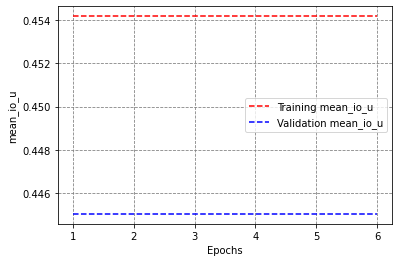

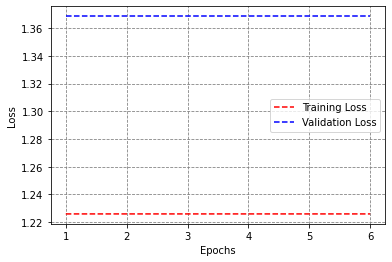

In [ ]:
# Plot the accuracy and Loss 
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

train_acc = hist.history['mean_io_u']
val_acc = hist.history['val_mean_io_u']

epoch_count = range(1, len(train_loss)+1)

# Visulaize with matplot lib

plt.plot(epoch_count, train_acc, 'r--')
plt.plot(epoch_count, val_acc, 'b--')
plt.grid(color='gray', linestyle='--')
plt.legend(['Training mean_io_u', 'Validation mean_io_u'])
plt.xlabel('Epochs')
plt.ylabel('mean_io_u')
plt.show()


plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b--')
plt.grid(color='gray', linestyle='--')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Testing

In [ ]:
model = load_model('/content/UNet_Model.h5')


testimgPath = '/content/drive/MyDrive/Datasets/fish dataset/test/Black Sea Sprat/*.png'
testmaskPath = '/content/drive/MyDrive/Datasets/fish dataset/test/Black Sea Sprat GT/*.png'

testimg_names = glob.glob(testimgPath)
testmask_names = glob.glob(testmaskPath)

testimg_names.sort()
testmask_names.sort()

testData = {'image':[], 'mask':[]}

testData = loadImages(testData, testimg_names, testmask_names, shape)

X_test = np.array(testData['image'])
y_test = np.array(testData['mask'])

In [ ]:
# Make predictions

# load only the first 10 images from the test set
X_test_subset = X_test[:5]
y_test_subset = y_test[:5]

# make predictions on the subset of the test data
predictions = model.predict(X_test_subset)


def plotter(X_test, y_test, predictions):
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,3,1)
    plt.imshow(X_test)
    plt.title("Image")
    
    plt.subplot(1,3,2)
    plt.imshow(y_test)
    plt.title("Ground Truth")
    
    plt.subplot(1,3,3)
    plt.imshow(predictions)
    plt.title("Predicted Mask")
    

for i in range(len(X_test_subset)):
    plotter(X_test_subset[i], y_test_subset[i], predictions[i][:,:,0])